In [ ]:
import sys, os

# Get project root — one level up from "research-report-generation"
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\birok\Python\LLMOPs\research-report-generation


In [5]:
from src.utils.model_loader import ModelLoader

In [6]:
model_loader = ModelLoader()

{"timestamp": "2025-12-14T14:02:01.973731Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"timestamp": "2025-12-14T14:02:01.973731Z", "level": "info", "event": "AWS_SECRET_ACCESS_KEY loaded successfully from environment"}
{"timestamp": "2025-12-14T14:02:01.979191Z", "level": "info", "event": "AWS_ACCESS_KEY_ID loaded successfully from environment"}
{"timestamp": "2025-12-14T14:02:01.979191Z", "level": "info", "event": "AWS_DEFAULT_REGION loaded successfully from environment"}
{"path": "C:\\Users\\birok\\Python\\LLMOPs\\research-report-generation\\src\\config\\configuration.yaml", "keys": ["astra_db", "embedding_model", "retriver", "llm"], "timestamp": "2025-12-14T14:02:01.980821Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["astra_db", "embedding_model", "retriver", "llm"], "timestamp": "2025-12-14T14:02:01.980821Z", "level": "info", "event": "YAML config loaded"}


In [7]:
llm=model_loader.load_llm()

{"provider": "groq", "model": "openai/gpt-oss-120b", "timestamp": "2025-12-14T14:02:28.448473Z", "level": "info", "event": "Loading LLM"}
{"provider": "groq", "model": "openai/gpt-oss-120b", "timestamp": "2025-12-14T14:02:28.803432Z", "level": "info", "event": "LLM loaded successfully"}


In [9]:
llm.invoke("Hello").content

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [10]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [25]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [12]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    role: str= Field(description="Role of the analyst in the context of the topic")
    affiliation:str= Field(description="Primary affiliation of tyhe analyst")
    description: str= Field(description="Description of the analyst focus, concerns, and motives")

    @property
    def persona(self)->str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

In [15]:
analyst=Analyst(
    name="Biro Kishore Das",
    role="AI Engineer",
    affiliation="Wipro",
    description="I am an AI engineer who works on AI and Classical ML"
)

In [16]:
print(analyst.name)
print(analyst.role)
print(analyst.affiliation)
print(analyst.description)

Biro Kishore Das
AI Engineer
Wipro
I am an AI engineer who works on AI and Classical ML


In [17]:
print(analyst.persona)

Name: Biro Kishore Das
Role: AI Engineer
Affiliation: Wipro
Description: I am an AI engineer who works on AI and Classical ML



In [28]:
class Perspectives(BaseModel):
    analysts: List[Analyst]= Field(description="Comprehensive list of analysts with their roles and affiliations")

In [19]:
class GenerateAnalystsState(TypedDict):
    topic: str #Research Topic
    max_analysts: int #number of analyst
    human_analyst_feedback: str #Human Feedback
    analysts: List[Analyst] #Analyst asking questions

In [21]:
GenerateAnalystsState(
    topic= "finance",
    max_analysts=5,
    human_analyst_feedback="Give me the real info"
)

{'topic': 'finance',
 'max_analysts': 5,
 'human_analyst_feedback': 'Give me the real info'}

In [22]:
Analyst(
    name="Dr. Bhibhudutta Das",
    role="Medical Data Scientist",
    affiliation="Appolo",
    description="Focuses on predictive models for patient outcomes"
)

Analyst(name='Dr. Bhibhudutta Das', role='Medical Data Scientist', affiliation='Appolo', description='Focuses on predictive models for patient outcomes')

In [23]:
analyst_instructions= """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully.
1. Review the research topic:
    {topic}
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
    {human_analyst_feedback}
3. Determine the most interesting themes based upon documents and/or feedback above.
4. Pick the top {max_analysts} themes
5. Assign one analyst to each theme."""

In [24]:
print([analyst_instructions.format(
    topic="AI in Healthcare",
    human_analyst_feedback="Focus on recent advancements and ethical considerations.",
    max_analysts=3
)] + ["Generate the set of analyst"])

['You are tasked with creating a set of AI analyst personas. Follow these instructions carefully.\n1. Review the research topic:\n    AI in Healthcare\n2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:\n    Focus on recent advancements and ethical considerations.\n3. Determine the most interesting themes based upon documents and/or feedback above.\n4. Pick the top 3 themes\n5. Assign one analyst to each theme.', 'Generate the set of analyst']


In [26]:
def create_analyst(state: GenerateAnalystsState):
    """
    It is creating my analyst"""
    topic= state["topic"]
    max_analysts= state["max_analysts"]
    human_analyst_feedback= state.get("human_analyst_feedback")

    structured_llm= llm.with_structured_output(Perspectives)

    system_messages= analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )
    analysts= structured_llm.invoke([SystemMessage(content=system_messages)] +[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

In [29]:
create_analyst({
    'topic': 'health',
    "max_analysts": 2,
    "human_analyst_feedback":"Give me the real info"})

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Maya Patel', role='Public Health Policy Analyst', affiliation='World Health Organization (WHO)', description='Specializes in analyzing global health data, evaluating policy impacts, and translating complex epidemiological findings into actionable recommendations. Prioritizes evidence-based insights to guide governments and NGOs toward effective, equitable health interventions.'),
  Analyst(name='Alex Rivera', role='Health Misinformation Analyst', affiliation='Center for Digital Health Integrity', description='Focuses on tracking, debunking, and countering health-related misinformation across social media and online platforms. Utilizes data-driven fact‑checking methods to ensure the public receives accurate, real information about medical treatments, vaccines, and wellness trends.')]}

In [30]:
def human_feedback(state):
    """No-op node that should be interrupted on"""
    pass

In [36]:
def should_continue(state):
    feedback= (state.get("human_analyst_feedback") or "").strip().lower()
    if feedback and feedback not in ["", "none", "skip", "done", "continue"]:
        return "create_analyst"
    return END

## First Workflow

In [31]:
from IPython.display import display, Image

In [33]:
builder= StateGraph(GenerateAnalystsState)

In [34]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [37]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                              should_continue,
                              ["create_analyst", END])

In [38]:
memory= MemorySaver()

In [40]:
graph=builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

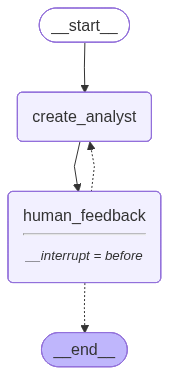

In [41]:
graph

In [42]:
topic="the benefits of adopting Langgraph as an agent framework"

In [46]:
max_analysts=4

In [44]:
thread={"configurable":{"thread_id":1}}

In [47]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Patel
Affiliation: Institute for Scalable AI Systems
Role: Performance & Scalability Analyst
Description: Focuses on benchmarking Langgraph's runtime efficiency, concurrency handling, and resource utilization compared to alternative agent frameworks. Concerned with latency, throughput, and scalability in large‑scale deployments.
--------------------------------------------------
Name: Alex Chen
Affiliation: DevOps Labs, Inc.
Role: Developer Experience Analyst
Description: Evaluates the ergonomics of building, testing, and debugging agents with Langgraph. Highlights productivity gains, learning curve, tooling support, and documentation quality for engineering teams.
--------------------------------------------------
Name: Sofia García
Affiliation: Enterprise Integration Consortium
Role: Ecosystem & Interoperability Analyst
Description: Assesses how Langgraph connects with existing data pipelines, APIs, LLM providers, and orchestration platforms. Looks at plug‑in architect

In [48]:
state= graph.get_state(thread)

In [49]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'analysts': [Analyst(name='Dr. Maya Patel', role='Performance & Scalability Analyst', affiliation='Institute for Scalable AI Systems', description="Focuses on benchmarking Langgraph's runtime efficiency, concurrency handling, and resource utilization compared to alternative agent frameworks. Concerned with latency, throughput, and scalability in large‑scale deployments."), Analyst(name='Alex Chen', role='Developer Experience Analyst', affiliation='DevOps Labs, Inc.', description='Evaluates the ergonomics of building, testing, and debugging agents with Langgraph. Highlights productivity gains, learning curve, tooling support, and documentation quality for engineering teams.'), Analyst(name='Sofia García', role='Ecosystem & Interoperability Analyst', affiliation='Enterprise Integration Consortium', description='Assesses how Langgraph connects with existing data pipelines, APIs, L

In [50]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'analysts': [Analyst(name='Dr. Maya Patel', role='Performance & Scalability Analyst', affiliation='Institute for Scalable AI Systems', description="Focuses on benchmarking Langgraph's runtime efficiency, concurrency handling, and resource utilization compared to alternative agent frameworks. Concerned with latency, throughput, and scalability in large‑scale deployments."),
  Analyst(name='Alex Chen', role='Developer Experience Analyst', affiliation='DevOps Labs, Inc.', description='Evaluates the ergonomics of building, testing, and debugging agents with Langgraph. Highlights productivity gains, learning curve, tooling support, and documentation quality for engineering teams.'),
  Analyst(name='Sofia García', role='Ecosystem & Interoperability Analyst', affiliation='Enterprise Integration Consortium', description='Assesses how Langgraph connects with existing data pipelines, APIs, LLM providers, a

In [51]:
state.next

('human_feedback',)

In [52]:
memory.storage.items()

dict_items([('1', defaultdict(<class 'dict'>, {'': {'1f0d8fce-5bc4-675d-bfff-1ed19476c3cf': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-12-14T14:55:14.616508+00:00\xa2id\xd9$1f0d8fce-5bc4-675d-bfff-1ed19476c3cf\xb0channel_versions\x81\xa9__start__\xd9100000000000000000000000000000001.0.67524691548226\xadversions_seen\x81\xa9__input__\x80\xb0updated_channels\x91\xa9__start__'), ('msgpack', b'\x83\xa6source\xa5input\xa4step\xff\xa7parents\x80'), None), '1f0d8fce-5bd6-6222-8000-470439577ee0': (('msgpack', b'\x86\xa1v\x04\xa2ts\xd9 2025-12-14T14:55:14.623747+00:00\xa2id\xd9$1f0d8fce-5bd6-6222-8000-470439577ee0\xb0channel_versions\x83\xa9__start__\xd9300000000000000000000000000000002.0.4369419289878157\xa5topic\xd9300000000000000000000000000000002.0.4369419289878157\xb8branch:to:create_analyst\xd9300000000000000000000000000000002.0.4369419289878157\xadversions_seen\x82\xa9__input__\x80\xa9__start__\x81\xa9__start__\xd9100000000000000000000000000000001.0.67524691548226\xb0updated_channels\x9

In [53]:
state.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d8fcf-c20f-6f20-8003-a4541cc60fff'}}

In [54]:
graph.update_state(thread,
                   {"human_analyst_feedback": "Add something from the startup perspective and focus on the lastest enterprise application"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d8fdb-7bdb-69e9-8004-999089bb04ab'}}

In [55]:
for event in graph.stream({"topic":topic,
              "max_analysts":max_analysts},
             thread,
             stream_mode= "values"):
    analysts = event.get('analysts', '')
    
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Maya Patel
Affiliation: Institute for Scalable AI Systems
Role: Performance & Scalability Analyst
Description: Focuses on benchmarking Langgraph's runtime efficiency, concurrency handling, and resource utilization compared to alternative agent frameworks. Concerned with latency, throughput, and scalability in large‑scale deployments.
--------------------------------------------------
Name: Alex Chen
Affiliation: DevOps Labs, Inc.
Role: Developer Experience Analyst
Description: Evaluates the ergonomics of building, testing, and debugging agents with Langgraph. Highlights productivity gains, learning curve, tooling support, and documentation quality for engineering teams.
--------------------------------------------------
Name: Sofia García
Affiliation: Enterprise Integration Consortium
Role: Ecosystem & Interoperability Analyst
Description: Assesses how Langgraph connects with existing data pipelines, APIs, LLM providers, and orchestration platforms. Looks at plug‑in architect

HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Maya Patel
Affiliation: GlobalTech Solutions (Enterprise AI Division)
Role: Enterprise Scalability Analyst
Description: Focuses on how Langgraph handles large-scale, high-throughput workloads, latency, and reliability in mission-critical enterprise environments. Concerned with performance benchmarks, fault tolerance, and compliance.
--------------------------------------------------
Name: Liam Chen
Affiliation: SparkForge Labs (AI Startup Accelerator)
Role: Startup Innovation Analyst
Description: Evaluates Langgraph's rapid prototyping capabilities, ease of onboarding, and flexibility for early-stage teams. Emphasizes time-to-market, developer experience, and lean resource usage.
--------------------------------------------------
Name: Sofia Alvarez
Affiliation: IntegrateX Corp (Systems Integration Consultancy)
Role: Enterprise Integration Specialist
Description: Examines how Langgraph plugs into existing enterprise stacks—ERP, CRM, data lakes, and legacy APIs. Looks at conne

In [56]:
state= graph.get_state(thread)

In [57]:
state

StateSnapshot(values={'topic': 'the benefits of adopting Langgraph as an agent framework', 'max_analysts': 4, 'human_analyst_feedback': 'Add something from the startup perspective and focus on the lastest enterprise application', 'analysts': [Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph handles large-scale, high-throughput workloads, latency, and reliability in mission-critical enterprise environments. Concerned with performance benchmarks, fault tolerance, and compliance.'), Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='SparkForge Labs (AI Startup Accelerator)', description="Evaluates Langgraph's rapid prototyping capabilities, ease of onboarding, and flexibility for early-stage teams. Emphasizes time-to-market, developer experience, and lean resource usage."), Analyst(name='Sofia Alvarez', role='Enterprise Integration Specialist', aff

In [58]:
state.next

('human_feedback',)

In [59]:
state.values

{'topic': 'the benefits of adopting Langgraph as an agent framework',
 'max_analysts': 4,
 'human_analyst_feedback': 'Add something from the startup perspective and focus on the lastest enterprise application',
 'analysts': [Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph handles large-scale, high-throughput workloads, latency, and reliability in mission-critical enterprise environments. Concerned with performance benchmarks, fault tolerance, and compliance.'),
  Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='SparkForge Labs (AI Startup Accelerator)', description="Evaluates Langgraph's rapid prototyping capabilities, ease of onboarding, and flexibility for early-stage teams. Emphasizes time-to-market, developer experience, and lean resource usage."),
  Analyst(name='Sofia Alvarez', role='Enterprise Integration Specialist', affiliation='Inte

In [60]:
# If we are satisfied, then simply supply no feedback
further_feedback=""

In [61]:
# 1. Get the latest state
state= graph.get_state(thread)

# 2. Use the exact config from that state (if already has thread_id, checkpoint_ns, checkpoint_id)
cfg= state.config

# 3. Update the feedback at the "human_feedback" node
#        Tip: if your TypedDict says 'human_analyst_feedback: str', prefer empty string "" over None
graph.update_state(cfg, {'human_analyst_feedback': ""}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0d8fec-4e05-6188-8008-17de5717ce1c'}}

In [62]:
# 4. Verify it moved to END
final_state= graph.get_state(thread)
print(final_state.next)

()


In [63]:
analysts

[Analyst(name='Dr. Maya Patel', role='Enterprise Scalability Analyst', affiliation='GlobalTech Solutions (Enterprise AI Division)', description='Focuses on how Langgraph handles large-scale, high-throughput workloads, latency, and reliability in mission-critical enterprise environments. Concerned with performance benchmarks, fault tolerance, and compliance.'),
 Analyst(name='Liam Chen', role='Startup Innovation Analyst', affiliation='SparkForge Labs (AI Startup Accelerator)', description="Evaluates Langgraph's rapid prototyping capabilities, ease of onboarding, and flexibility for early-stage teams. Emphasizes time-to-market, developer experience, and lean resource usage."),
 Analyst(name='Sofia Alvarez', role='Enterprise Integration Specialist', affiliation='IntegrateX Corp (Systems Integration Consultancy)', description='Examines how Langgraph plugs into existing enterprise stacks—ERP, CRM, data lakes, and legacy APIs. Looks at connector libraries, data governance, and orchestration 

In [64]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Maya Patel
Affiliation: GlobalTech Solutions (Enterprise AI Division)
Role: Enterprise Scalability Analyst
Description: Focuses on how Langgraph handles large-scale, high-throughput workloads, latency, and reliability in mission-critical enterprise environments. Concerned with performance benchmarks, fault tolerance, and compliance.
--------------------------------------------------
Name: Liam Chen
Affiliation: SparkForge Labs (AI Startup Accelerator)
Role: Startup Innovation Analyst
Description: Evaluates Langgraph's rapid prototyping capabilities, ease of onboarding, and flexibility for early-stage teams. Emphasizes time-to-market, developer experience, and lean resource usage.
--------------------------------------------------
Name: Sofia Alvarez
Affiliation: IntegrateX Corp (Systems Integration Consultancy)
Role: Enterprise Integration Specialist
Description: Examines how Langgraph plugs into existing enterprise stacks—ERP, CRM, data lakes, and legacy APIs. Looks at conne

In [65]:
from langchain_community.document_loaders import WikipediaLoader
docs= WikipediaLoader(query="AWS").load()
print(docs[0].page_content[:500])

c:\Users\birok\Python\LLMOPs\research-report-generation\venv\Lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\birok\Python\LLMOPs\research-report-generation\venv\Lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Amazon Web Services, Inc. (AWS) is a subsidiary of Amazon that provides on-demand cloud computing platforms and APIs to individuals, companies, and governments, on a metered, pay-as-you-go basis.
Clients often use this in combination with autoscaling (a process that allows a client to use more computing in times of high application usage, and then scale down to reduce costs when there is less traffic). These cloud computing web services provide various services related to networking, compute, st


In [67]:
from langchain_community.utilities import WikipediaAPIWrapper
wiki = WikipediaAPIWrapper(doc_content_chars_max=4000)
docs = wiki.run("The benefits of adopting LangGraph as an agentic framework")
print(docs)

Page: Semantic Web
Summary: The Semantic Web, sometimes known as Web 3.0, is an extension of the World Wide Web through standards set by the World Wide Web Consortium (W3C). The goal of the Semantic Web is to make Internet data machine-readable.
To enable the encoding of semantics with the data, technologies such as Resource Description Framework (RDF) and Web Ontology Language (OWL) are used. These technologies are used to formally represent metadata. For example, ontology can describe concepts, relationships between entities, and categories of things. These embedded semantics offer significant advantages such as reasoning over data and operating with heterogeneous data sources.
These standards promote common data formats and exchange protocols on the Web, fundamentally the RDF. According to the W3C, "The Semantic Web provides a common framework that allows data to be shared and reused across application, enterprise, and community boundaries." The Semantic Web is therefore regarded as

## Second Workflow